<a href="https://colab.research.google.com/github/mett29/DL-Competition/blob/master/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image classification challenge for ANNDL 2019-2020
Made by :

LEADERBOARD NICKNAME : 10527332_10527346

NAME_1: Mattia

LAST-NAME_1: Mancassola

STUDENT-ID_1:10527332

NAME_2: Daniele

LAST-NAME_2: Parravicini

STUDENT-ID_2 :10527346

We used Colab and Kaggle to train and evaluate our models

we had split the dataset for validation purposes sometimes at 20% and sometimes at 10% depending on the particular model under consideration. Follows the details about dataset split used for the last models.

The first part of the notebook describes the combination of dataset/models that yielded the best results.

In the end of the notebook we report several tests we have carried out, that we had expected to yield better results but turned out to be unfeasible (due to the huge amount of time taken for training) or simply to worse the results.


In [0]:

# This permits to load the dataset on colab.
# We chose to take advantage of github to rapidly load all the data on colab.

from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/DanieleParravicini/DL-CompetitionsDatasets
os.environ['GITHUB_AUTH'] = ''

# Of course it is not mandatory to load the dataset from a remote repo.
# You can simply unpack the kaggle competition zip in a local directory named 'DL-CompetitionsDatasets'
# As depicted below:

Github user··········
Github password··········
Cloning into 'DL-CompetitionsDatasets'...
remote: Enumerating objects: 18606, done.
remote: Total 18606 (delta 0), reused 0 (delta 0), pack-reused 18606
Receiving objects: 100% (18606/18606), 1.37 GiB | 37.51 MiB/s, done.
Resolving deltas: 100% (7114/7114), done.
Checking out files: 100% (18582/18582), done.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance 
from PIL import ImageOps  
import cv2

import time
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from keras.utils import plot_model


2.0.0


# Loading datasets

In [0]:
SEED = 2019
tf.random.set_seed(SEED)

In [0]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
PATH = ''
on_kaggle = False
if on_kaggle: 
  PATH = "/kaggle/input/ann-and-dl-image-segmentation/Segmentation_Dataset"
else:
  PATH = 'DL-CompetitionsDatasets/Segmentation_Dataset'

batch_size = 32

In [0]:
apply_data_augmentation = False

# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                        zoom_range=[0.5,1],
                                        horizontal_flip=True,
                                        vertical_flip=True,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                        zoom_range=[0.5,1],
                                        horizontal_flip=True,
                                        vertical_flip=True,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2) 
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [0]:
dataset_dir = os.path.join(PATH, 'training')

train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               #interpolation='bilinear',
                                               seed=SEED)

train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               #interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

train_gen = zip(train_img_gen, train_mask_gen)

# Validation
valid_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               #interpolation='bilinear',
                                               seed=SEED)

valid_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               #interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

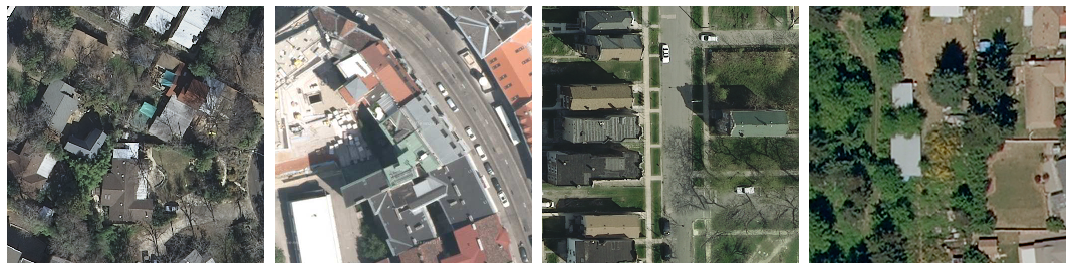

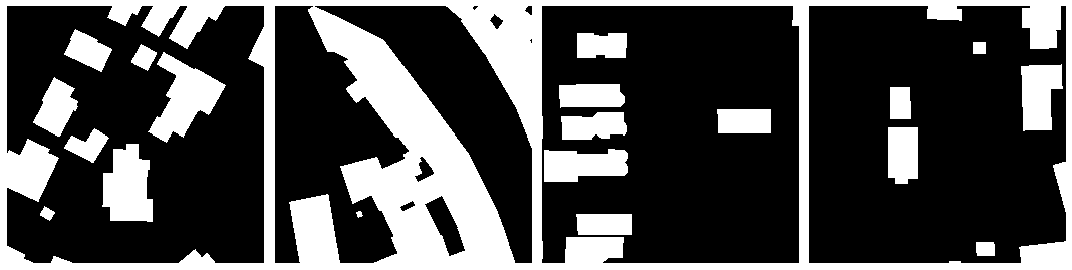

In [0]:
def grayscale_to_colour(gray_img):
  
  black = [0, 0, 0] # Background
  white = [255, 255, 255] # Buildings

  colour_img = np.zeros([gray_img.shape[0], gray_img.shape[1], 3])
  return np.where(gray_img == 1, white, black )


sample_training_images, sample_training_masks = next(train_gen)
plotImages(sample_training_images[:4])
sample_training_masks_imaged = list(map( grayscale_to_colour ,sample_training_masks[:4]))
plotImages(sample_training_masks_imaged)

In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

'''When using data augmentation on masks it's a good idea to cast mask tensor to tf.int32. 
When applying geometric transformations, like rotation or zoom, the output is interpolated so you will end up with values in [0, 1] 
which are no longer binary. Casting to integer will allow to obtain again binary masks.'''

def prepare_target(x_, y_):
    y2_ = tf.cast(tf.cast(y_, tf.int32), tf.float32)
    return x_, y2_

train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()
train_dataset_cached = train_dataset.cache()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

valid_dataset = valid_dataset.map(prepare_target)
valid_dataset = valid_dataset.repeat()
valid_dataset_cached = valid_dataset.cache()

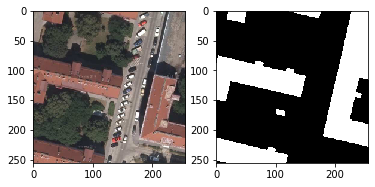

In [0]:
fig, ax = plt.subplots(1, 2)
fig.show()

colors_dict = {}
colors_dict[0] = [0, 0, 0] # Background
colors_dict[1] = [255, 255, 255] # Buildings

iterator = iter(train_dataset)

for _ in range(1):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]
    augmented_img = augmented_img * 255
    
    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(grayscale_to_colour(target[0])))

# Model

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    d = tf.keras.layers.SpatialDropout2D(0.1)(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(d)
    return d, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    #us = tf.keras.layers.UpSampling2D((2, 2))(x)
    us =  tf.keras.layers.Conv2DTranspose(filters ,(2, 2), strides=(2,2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [0]:
def UNet():
    # Instead of a single model return an array of them
    # All of them share the convolution part of the network and 
    # part of the upsampling
    
    models = []
    
    f = [32, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    p0 = inputs
    
    downsampling_layers  = [p0]
    convolutional_layers = []
    # create a downsampling part of the network
    # and save the convolutions to enable creation of skip connection
    for i, n_filt in enumerate(f[:-1]):
        cx, px = down_block(downsampling_layers[i], n_filt) # spatial extent 2A x 2A -> A x A
        downsampling_layers.append(px)
        convolutional_layers.append(cx)
    
    bn = bottleneck(downsampling_layers[-1], f[-1])
    
    #create the upsampling part of the network
    upsampling_layers = [bn]
    for i, n_filt in enumerate(reversed(f[:-1]) ):
        ux = up_block(upsampling_layers[i], convolutional_layers[- i -1], n_filt ) # spatial extent A x A -> 2A x 2A
        upsampling_layers.append(ux)

    
    # for each upsampling layer create a model that can be trained with the same couple of full resolution 
    # image/mask as the whole nn.
    # In order to do so we have to upsample accordingly
    for i in range(len(upsampling_layers)-1):
        #up sample 
        upsampling_factor = 2 ** ( len(upsampling_layers) - i -1)
        upx     = tf.keras.layers.UpSampling2D((upsampling_factor, upsampling_factor))(upsampling_layers[i])
        outputx = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upx)
        nn_name = 'upsampled_'+str(upsampling_factor)
        models.append(tf.keras.models.Model(inputs, outputx, name=nn_name))

    #create the final model
    output = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upsampling_layers[-1])
    models.append( tf.keras.models.Model(inputs, output, name = "true_model"))
    return models

In [0]:
def IoU(y_true, y_pred):
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

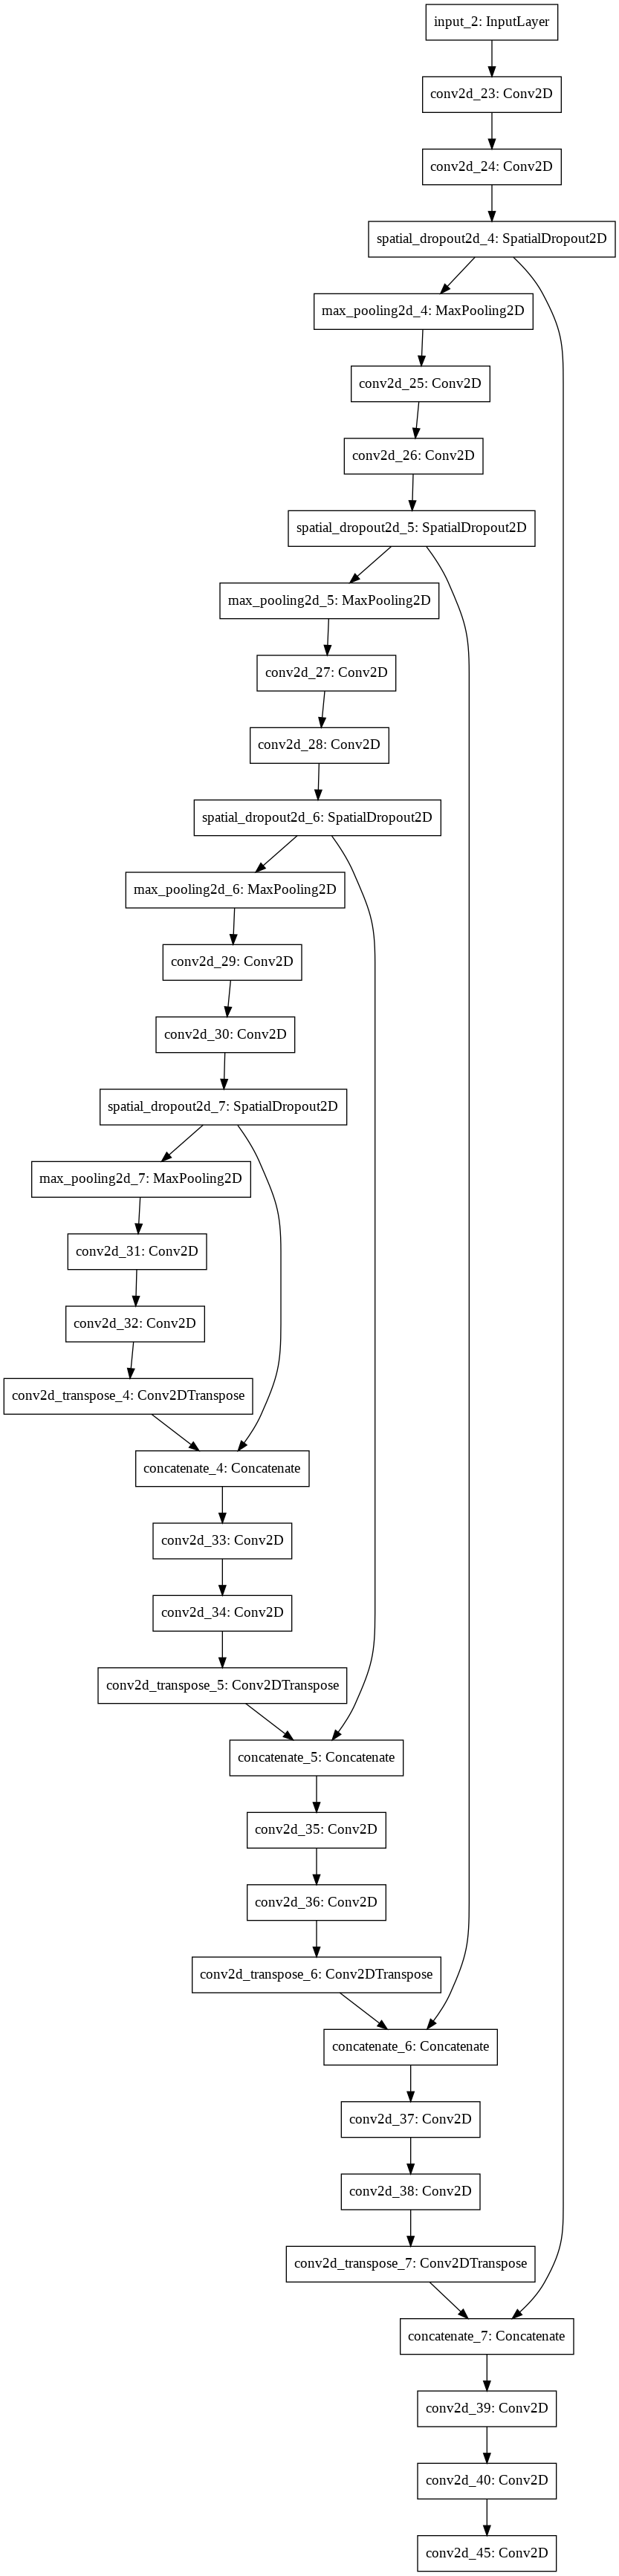

In [0]:
models = UNet()

from tensorflow.keras.utils import plot_model
#to visuallly check models
plot_model(models[-1])

In [0]:

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#compile
for i, m in enumerate(models):
    
    m.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[IoU])
    
    m.summary()

Model: "upsampled_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 32)     

# Training

In [0]:
from datetime import datetime

callbacks = []

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)

#reduce learning rate on plateu
# --------------
reduce_lr = True
if(reduce_lr):
    es_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)
    callbacks.append(es_callback )
    

In [0]:
for m in models:
    m.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks
          )

models[-1].save_weights("UNet_" + str(datetime.now().strftime('%b%d_%H-%M')) + ".h5")

Train for 192 steps, validate for 48 steps
Epoch 1/10
192/192 [==============================] - 49s 256ms/step - loss: 0.5732 - IoU: 0.1212 - val_loss: 0.4934 - val_IoU: 0.3915
Epoch 2/10
192/192 [==============================] - 47s 247ms/step - loss: 0.4447 - IoU: 0.4498 - val_loss: 0.4417 - val_IoU: 0.4338
Epoch 3/10
192/192 [==============================] - 47s 247ms/step - loss: 0.4014 - IoU: 0.5169 - val_loss: 0.3791 - val_IoU: 0.5299
Epoch 4/10
192/192 [==============================] - 47s 246ms/step - loss: 0.3799 - IoU: 0.5474 - val_loss: 0.3829 - val_IoU: 0.5075
Epoch 5/10
192/192 [==============================] - 48s 248ms/step - loss: 0.3614 - IoU: 0.5698 - val_loss: 0.3545 - val_IoU: 0.5862
Epoch 6/10
192/192 [==============================] - 47s 246ms/step - loss: 0.3478 - IoU: 0.5792 - val_loss: 0.3481 - val_IoU: 0.5809
Epoch 7/10
192/192 [==============================] - 47s 245ms/step - loss: 0.3406 - IoU: 0.5947 - val_loss: 0.3383 - val_IoU: 0.5803
Epoch 8/10
1

#Load model from weight file



# Upload weights file to kaggle/colab instances



In [0]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

In [0]:
for i, meta in enumerate(upload.metadata): 
    print(meta['name']) 
    with open(meta['name'], "w+b") as file_writer: 
        file_writer.write(upload.data[i])

Now you can load weigths: 

- model.load_weights
- model.load

and reevaluate their scores


In [0]:
models[-1].evaluate(valid_dataset,
          steps=len(valid_img_gen))

models[-1].evaluate(train_dataset,
          steps=len(train_img_gen))

48/48 [==============================] - 8s 169ms/step - loss: 0.2753 - IoU: 0.6739


[0.27531634146968526, 0.6738562]

# Evaluate results

In [0]:
#code snippet used to overlay the prediction and/or the target mask
# over the image to assess the performance of the model

def plotImageAndMask(img, mask=None, pred=None):
  red = (255, 0, 0)
  black = (0,0,0)
  white = (255,255,255)
  green = (0, 255,0)

  plt.figure(figsize=(15, 15))
  plt.imshow(img, 'gray', interpolation='none')
  if(mask is not None):
      transf_mask = np.where( mask == white , red , black )
      plt.imshow(transf_mask, interpolation='none', alpha=0.2)
  if(pred is not None):
      transf_pred = np.where( pred == white , green , black )
      plt.imshow(transf_pred, interpolation='none', alpha=0.2)
  plt.show()
  #in red what has to be captured
  #in green what is captured only by our model
  #in orange what is captured by both


This procedure was used after training to compare the expected mask and the prediction
1. Fill the results object with the masks

In [0]:
def prediction_to_mask(prediction):
  return tf.cast(prediction > 0.5, tf.float32)


image_filenames = next(os.walk(PATH+'/training/images/img'))[2]

results = {}
for image_name in image_filenames[:15]:

    img = image.load_img(os.path.join(PATH+'/training/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255. 
    
    #take the name of the file disregarding of the extension 
    name_without_ext = image_name[:-4]
    #obtain the prediction from the model
    prediction = models[-1].predict(img_tensor)[0]
   
    #transform into a mask
    results[name_without_ext] = prediction_to_mask(prediction)


2. Plot the results

In [0]:
for image_name in results:
  #obtain the image from file
  img = image.load_img(os.path.join(PATH+'/training/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
  #obtain the mask from file
  mask1 = image.load_img(os.path.join(PATH+'/training/masks/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))

  pred = results[image_name]

  mask2 = grayscale_to_colour(pred)
  plotImageAndMask(img, image.img_to_array(mask1), mask2)

# Collect results 

In [0]:
def prediction_to_mask(prediction):
  return tf.cast(prediction > 0.5, tf.float32)


image_filenames = next(os.walk(PATH+'/test/images/img'))[2]

results = {}
for image_name in image_filenames[:]:

    img = image.load_img(os.path.join(PATH+'/test/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255. 
    
    #take the name of the file disregarding of the extension 
    name_without_ext = image_name[:-4]
    #obtain the prediction from the model
    prediction = models[-1].predict(img_tensor)[0]
    #transform into a mask and store into result object
    results[name_without_ext] = prediction_to_mask(prediction)

In [0]:
#Optional visualization of the results
for image_name in results:
  img = image.load_img(os.path.join(PATH+'/test/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
  #mask1 = image.load_img(os.path.join(PATH+'/training/masks/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))

  pred = results[image_name]

  mask2 = grayscale_to_colour(pred)

  plotImageAndMask(img, pred=mask2)

# Producing the csv for submission

In [0]:
def rle_encode(img):
    # Flatten column-wise
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

        f.write('ImageId,EncodedPixels,Width,Height\n')

        for key, value in results.items():
            f.write(key + ',' + str(rle_encode(np.array(value))) + ',' + '256' + ',' + '256' + '\n')

In [0]:
create_csv(results)

# Interesting thing that could have worked

### Training and model

*   Successive optimization of each upsampling layer.
Following [Fully Convolutional Networks for Semantic Segmentation](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) we have built several overlapping models. In this case we have considered a UNet and from the bottleneck layer every time we introduce a block in which was present an upsampling we did the following: 
    1. take the output of such a layer 
    2. properly increase the spatial extent exploiting an upsampling layer without parameters (nearest) directly to output resolution (256x256) 
    3. add 1x1 convolution 
    4. add a sigmoid activation.

We train the models starting from the block that require the highest upsampling factor, and ending with the lowest. 
Optimizing with 10-30 epochs at each layer we noticed a 2% increment of IoU (0.48743 to 0.50867).


In [0]:
'''
exploiting the follwoing functions
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
  '''

def UNet():
    # Instead of a single model return an array of them
    # All of them share the convolution part of the network and 
    # part of the upsampling
    
    models = []
    
    f = [16,32,64,128]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))
    p0 = inputs
    
    downsampling_layers  = [p0]
    convolutional_layers = []
    # create a downsampling part of the network
    # and save the convolutions to enable creation of skip connection
    for i, n_filt in enumerate(f[1:-1]):
        cx, px = down_block(downsampling_layers[i], n_filt) # spatial extent 2A x 2A -> A x A
        downsampling_layers.append(px)
        convolutional_layers.append(cx)
    
    bn = bottleneck(downsampling_layers[-1], f[-1])
    
    #create the upsampling part of the network
    upsampling_layers = [bn]
    for i, n_filt in enumerate(reversed(f[1:-1]) ):
        ux = up_block(upsampling_layers[i], convolutional_layers[- i -1], n_filt ) # spatial extent A x A -> 2A x 2A
        upsampling_layers.append(ux)

    
    # for each upsampling layer create a model that can be trained with the same couple of full resolution 
    # image/mask as the whole nn.
    # In order to do so we have to upsample accordingly
    for i in range(len(upsampling_layers)-1):
        #up sample 
        upsampling_factor = 2 ** ( len(upsampling_layers) - i -1)
        upx     = tf.keras.layers.UpSampling2D((upsampling_factor, upsampling_factor))(upsampling_layers[i])
        outputx = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upx)
        nn_name = 'upsampled_'+str(upsampling_factor)
        models.append(tf.keras.models.Model(inputs, outputx, name=nn_name))

    #create the final model
    output = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(upsampling_layers[-1])
    models.append( tf.keras.models.Model(inputs, output, name = "true_model"))
    
    return models

* [Follows from the previous comment...] One could argue that each time we stop optimizing a model and we move to the following one we are throwing a number of  layers(proper upsampling, 1x1 convolution, 1 sigmoid). We have tried to recombine those information in a new model.


In [0]:

def UNet():
    # Modifications required to perform such a task 
    [...]
    
    outputs = []
    for m in models:
      outputs.append(m.output)
    
    conc = tf.keras.layers.Concatenate()(outputs)
    outputx = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(conc)
    models.append( tf.keras.models.Model(inputs, outputx, name = "true_true_model"))

    return models
    


Based on [Dense U-net based on patch-based learning for Retinal Vessel Segmentation](https://www.mdpi.com/1099-4300/21/2/168) and [Road Extraction by Deep Residual U-Net](https://arxiv.org/pdf/1711.10684.pdf)

* Add residual link to the downsampling/upsampling blocks
![](https://www.mdpi.com/entropy/entropy-21-00168/article_deploy/html/images/entropy-21-00168-g003a-550.jpg)
* Foster the reutilization of results produced in the bottleneck.
![](https://www.mdpi.com/entropy/entropy-21-00168/article_deploy/html/images/entropy-21-00168-g003b-550.jpg)

Here follows the reformulation of down sampling/up sampling blocks/ bottleneck blocks to obtain DenseUNet

In [0]:

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(x)
    n = tf.keras.layers.BatchNormalization()(c)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(n)
    n = tf.keras.layers.BatchNormalization()(c)
    residual = tf.keras.layers.Add()([n, x])
    
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(residual)
    
    return residual, p


def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    #us = tf.keras.layers.UpSampling2D((2, 2))(x)
    us =  tf.keras.layers.Conv2DTranspose(filters ,(2, 2), strides=(2,2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    d = tf.keras.layers.SpatialDropout2D(0.2)(concat)

    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(d)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(c)
    c = tf.keras.layers.Add()([us, c])
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c1 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(x)
    
    c2 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(c1)
    conc2 = tf.keras.layers.Concatenate()([c1,c2])
    c3 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(conc2)
    conc3 = tf.keras.layers.Concatenate()([c1,c2,c3])
    c4 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(conc3)
    conc4 = tf.keras.layers.Concatenate()([c1,c2,c3,c4])
    c5 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="elu")(conc4)
   
    return c5

    

### Preprocessing

1. [consider only red channel](https://pdfs.semanticscholar.org/4d37/ddb41c799e67ed2d2a5f16fe2156dbec8959.pdf) (~.66 IoU)
2. Run Histogram Equalization / Local Equalization on input images (negligible improvement)
3. Give in input grayscale images (worse results)
4. Supply as an input an extra information, w.r.t. the plain image, coming from well known algorithms known in the context of Image Processing, such as the Sobel filter.


In order to mantain the freedom of applying whatever python function we want as a pre processing function we created an ad-hoc generator to feed the input pipeline

In [0]:
def loader(basepath=''):
    def loadFromFile(path):
        #print(basepath, path)
        if basepath is not '':
            path = basepath.decode("utf-8")  + '/'+ path.decode("utf-8") 
            
        img = Image.open(path)
        return np.array(img)
    return loadFromFile


class myDataset(tf.data.Dataset):
   
    def __new__(self, basepath, output_shapes, output_types, validation_split=0.0, seed=None, subset='training', funct = None ):
        self.basepath = basepath
        
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
      
        #print(os.listdir(basepath))
        files = [f for f in os.listdir(basepath) if os.path.isfile(basepath + "/" + f)]
        files = np.array(files)   
        np.random.shuffle(files)

        split_indx = round( validation_split * len(files) )

        if subset == 'validation':
            self.subset = files[:split_indx]
            self.number_of_items = split_indx
            
        else :
            self.subset = files[split_indx:]
            self.number_of_items =len(files)- split_indx
            
        print( self.number_of_items, 'files found')
        
        def producer_generator(funct):
            def generator(basepath,subset):
                
                loadFromFile = loader(basepath)
                res = map(loadFromFile,subset)

                if funct is not None:
                    print('executed:',funct)
                    res = map(funct, res)

                res = map(tf.convert_to_tensor, res)

                for el in iter(res):
                    yield el
                
            return generator
        
        generator = producer_generator(funct)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types=output_types,
            output_shapes=output_shapes,
            args = (self.basepath, self.subset)
        )
    
    def number_of_items(self):
        return self.number_of_items

  

In [0]:
def prepare_img(x):
    x = tf.cast(tf.cast(x, tf.int32), tf.float32)*1.0/255
    return x

def prepare_mask(x):
    x = tf.cast(tf.cast(x, tf.int32), tf.float32)*1.0/255
    return np.expand_dims(x, axis=-1)


In [0]:
training_steps,dataset_img = myDataset(PATH + '/training/images/img', 
                         output_shapes=[IMG_HEIGHT, IMG_WIDTH, 3],
                         output_types=tf.float32,
                         funct=prepare_img, 
                         validation_split=0.1, 
                         seed= SEED)

_, dataset_masks = myDataset(PATH + '/training/masks/img',
                        output_shapes=[IMG_HEIGHT, IMG_WIDTH, 1],
                        output_types=tf.float32,
                        funct=prepare_mask,
                        validation_split=0.1, 
                        seed= SEED)

train_dataset = tf.data.Dataset.zip((dataset_img,dataset_masks)).batch( batch_size,drop_remainder=True )
train_dataset_cached = train_dataset.cache()



validation_steps,dataset_valid_img = myDataset(PATH + '/training/images/img', 
                        [IMG_HEIGHT, IMG_WIDTH, 3],
                        tf.float32,
                        funct=prepare_img, 
                        validation_split=0.1,
                        subset = 'validation',
                        seed= SEED)

_,dataset_valid_masks = myDataset(PATH + '/training/masks/img',
                        output_shapes=[IMG_HEIGHT, IMG_WIDTH, 1],
                        output_types=tf.float32,
                        funct=prepare_mask,
                        validation_split=0.1,
                        subset = 'validation',
                        seed= SEED)


valid_dataset = tf.data.Dataset.zip((dataset_valid_img,dataset_valid_masks)).batch( batch_size,drop_remainder=True )
valid_dataset_cached = valid_dataset.cache()

There are several ways in which 
`prepare_img()`
can be written and this encapsulate the particula rpreprocessing function we want to accomplish

1. convert into PIL Image object and apply some filtering to cancel some noise in the image:
```
img = Image.fromarray(x.astype('uint8'), 'RGB')
#one of the following
img = img.filter(ImageFilter.MedianFilter(size=3))
img = img.filter(ImageFilter.GaussianBlur(radius=2))
img = img.filter(ImageFilter.MinFilter(size=5))
img = img.filter(ImageFilter.EDGE_ENHANCE)
img = ImageEnhance.Color(img).enhance(2.0)
return img
```
2.Enhance the contrast in the image by performing global or local histogram equalization
```
img  = ImageOps.equalize(img, mask = None) 
return img
```
or 
```
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img =clahe.apply(x)
return img
```
3. Extract a sort of feature from the input image and provide it as an additional input for the model, in the form of an extra channel
[ ImageFilter.FIND_EDGES == DIGITAL LAPLACIAN FILTER](https://pythontic.com/image-processing/pillow/edge-detection)
```
y = img.filter(ImageFilter.FIND_EDGES)  
y = np.array(y)
y = y[:,:,0]+y[:,:,1]+y[:,:,2]
y = np.where( y > 255 , 255, y ) 
y = np.expand_dims(y, axis=-1)
#in such a case to produce the output we have   concatenate to the image the extra channel
x1 = tf.cast(tf.cast(x, tf.int32), tf.float32)*1.0/255
y1 = tf.cast(tf.cast(y, tf.int32), tf.float32)*1.0/255
return np.concatenate((x1,y1), axis=-1) 
```



4. Enrich input dataset by creating syntetic Aerial Images by extracting buildings from original dataset and pasting them in random positions of input images (unfeasible training too long)


In [0]:
#function that load an image given its name and the basepath in which to search
def loader(basepath=''):
    def loadFromFile(path):
        #print(basepath, path)
        if basepath is not '':
            path = basepath.decode("utf-8")  + '/'+ path.decode("utf-8") 
            
        img = Image.open(path)
        return np.array(img)
    return loadFromFile

#function that extracts building randomly from the image supplied as an argument.
def get_random_building(img,mask):
  lbl, nlbl = ndimage.label(mask[:,:,0])

  
  assert(nlbl != 0)
  if nlbl == 1:
    chosen_building_lbl = 1
  else:
    chosen_building_lbl = np.random.randint(1,nlbl)
  #take a random label

  print(nlbl, 'buildings found; ', chosen_building_lbl, ' chosen')
  pos        = np.argwhere(lbl==chosen_building_lbl)
  #create the base image and mask
  mask_n     = np.zeros(img.shape) 
  building   = np.zeros(img.shape)
  #fill the image and the mask
  for p in pos:
      building[p[0],p[1]] = img[p[0],p[1]]
      mask_n[p[0],p[1]] = 1
  return building,mask_n


#fucntion used to collect a finite amount of buildings for later usage
def extract_buildings(imgs_and_masks, nr=100):
    rand_buildings = []
    it = iter(imgs_and_masks)

    for i in range(nr):
        img,mask = next(it)
        new_img, new_build = get_random_building(img,mask)
        rand_buildings.append(( new_img, new_build))
    return rand_buildings

# Fucntion that superimpose non-zero RGB pixels of image2/mask2 on top of image1/mask1.
# shx, shy are the number of pixels for which image2/mask2 is translated before superimposition. 
def overlay(img1, mask1, img2, mask2, shx=0, shy=0):
  
  pos = np.argwhere(mask2==1)
  
  for p in pos:
      
      if p[0]+shx < 0:
        continue
      if p[0]+shx > img1.shape[0]:
        continue
      if p[1]+shx < 0:
        continue
      if p[1]+shy > img1.shape[1]:
        continue
      
      img1[int(p[0]+shx),int(p[1]+shy)] = img2[p[0],p[1]]
      mask1[int(p[0]+shx),int(p[1]+shy),0] = 255

  return img1,mask1/255

# a class that generates syntetic couples of images/masks.
# this is a refinement of the previous class considered the fact that 
# we have to hold both image/mask to perform overlaying of a random building 
class mySyntheticDataset:
    def __new__(self, basepath1, basepath2, output_shapes, output_types,
                validation_split=0.0, seed=None, subset='training', 
                funct1 = None, funct2=None, functboth=None ):
        self.basepath1 = basepath1
        self.basepath2 = basepath2
        
        self.funct1 = funct1
        self.funct2 = funct2
        self.functboth = functboth
        self.output_types = output_types
        self.output_shapes = output_shapes
        
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
      
        # Take files from one of the two directory consider thateach file in basepath1 
        # are matched with a file with the same name under basepath2
        files = [f for f in os.listdir(basepath1) if os.path.isfile(basepath1 + "/" + f)]
        files = np.array(files)   
        np.random.shuffle(files)

        split_indx = round( validation_split * len(files) )

        if subset == 'validation':
            self.subset = files[:split_indx]
            self.number_of_items = split_indx
            
        else :
            self.subset = files[split_indx:]
            self.number_of_items =len(files)- split_indx
            
        print( self.number_of_items, 'files found')
        return self
    
    def number_of_items(self):
        return self.number_of_items
    
    def obtain_dataset(self):
        
        def producer_generator(funct1, funct2, functboth):
            def generator(basepath1, basepath2, subset):
                #Since has been used for testing purposes
                # this class is less general 

                #load images
                loadFromFile = loader(basepath1)
                images = map(loadFromFile,subset)
                #load masks
                loadFromFile = loader(basepath2)
                masks = map(loadFromFile,subset)
                #execute preprocessing functions
                #separately for images and masks
                if funct1 is not None:
                    print('executed:',funct1)
                    images = map(funct1, images)
                    
                if funct2 is not None:
                    print('executed:',funct2)
                    masks = map(funct2, masks)
                #arrange images and masks in couples
                res = zip(images, masks)
                #extract randomly 5 buildings
                buildings = extract_buildings(res,5)
                #yield couples images/masks after randomly superimposing
                # a building.
                while True:
                  for img1,mask1 in iter(res):

                      img2, mask2 = buildings[np.random.randint(len(buildings))]
                      
                      shx, shy = (np.random.random(2)-0.5)*255;

                      yield overlay(img1,mask1,img2,mask2, shx, shy )
                
            return generator
        
        generator = producer_generator(self.funct1, self.funct2, self.functboth)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types =self.output_types,
            output_shapes=self.output_shapes,
            args = (self.basepath1, self.basepath2, self.subset)
        )
    
def prepare_img(x):

    x = x*1.0/255.
    return x

def prepare_mask(x):
    x = tf.cast(x, tf.float32)*1.0/255.0
    return tf.expand_dims(x, axis=-1)

my_generator_train = mySyntheticDataset(PATH + '/training/images/img', 
                        PATH + '/training/masks/img',
                        output_shapes=([None, None, CH_INPUT], [None, None, 1]),
                        output_types=(tf.float32, tf.float32) ,
                        funct1=prepare_img, 
                        funct2 = lambda x: np.expand_dims(x,-1),
                        
                        validation_split=0.15, 
                        subset = 'training',
                        seed= SEED)

nr , train_dataset = my_generator_train.obtain_dataset(my_generator_train)

train_dataset = train_dataset.batch( batch_size,drop_remainder=True )

Example of building detection and extraction




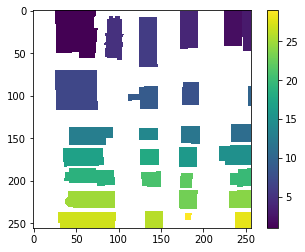

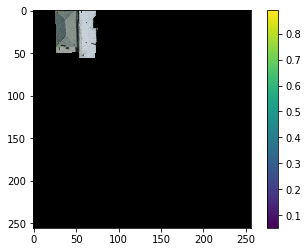


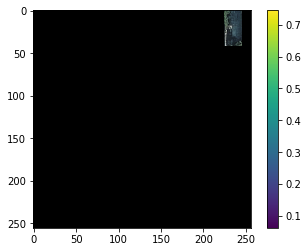

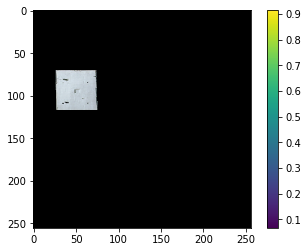

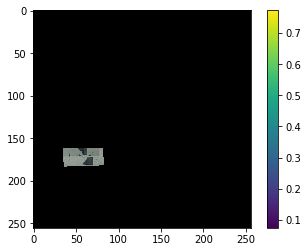



















Original image

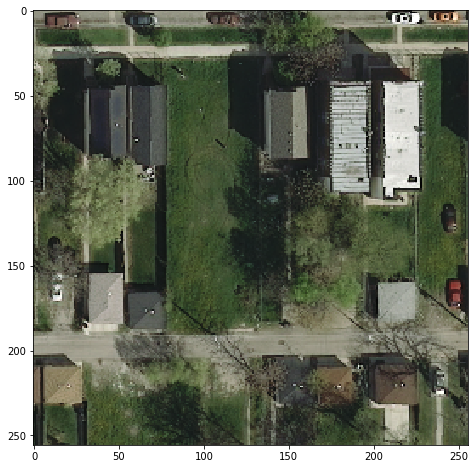

Augmented

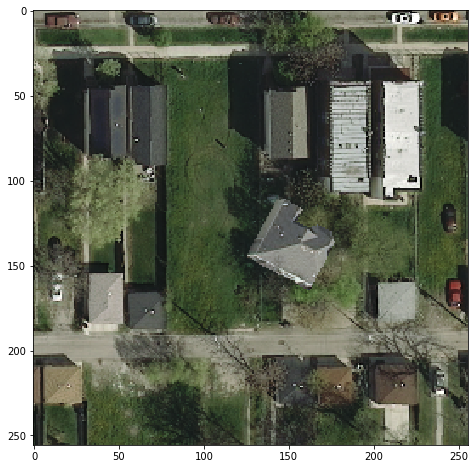

Follows an example of training using 10 batch (each made of 32) only for training and 1 for validation takes almost as 1 epoch without creating syntetic views.
Here we can note how long it takes to generate that dataset.
The messages that are printed are mainly for debugging purposes, and give some inshight on how buildings are extracted


```
training: upsampled_8
Train for 10 steps, validate for 1 steps
Epoch 1/30
executed: <function prepare_img at 0x7f1bd60bcc80>
executed: <function <lambda> at 0x7f1bd9895488>
29 buildings found;  25  chosen
9 buildings found;  2  chosen
10 buildings found;  6  chosen
2 buildings found;  1  chosen
5 buildings found;  4  chosen
executed: <function prepare_img at 0x7f1bd60bcc80>
executed: <function <lambda> at 0x7f1bdad9bbf8>
3 buildings found;  1  chosen
14 buildings found;  1  chosen
4 buildings found;  1  chosen
3 buildings found;  2  chosen
14 buildings found;  10  chosen
10/10 [==============================] - 51s 5s/step - loss: 30.0775 - IoU: 0.1313 - val_loss: 6.1686 - val_IoU: 0.2106
[...]
Epoch 7/30
 9/10 [==========================>...] - ETA: 5s - loss: 1.0129 - IoU: 0.2894 
executed: <function prepare_img at 0x7f1bd60bcc80>
executed: <function <lambda> at 0x7f1bdad9bbf8>
3 buildings found;  1  chosen
14 buildings found;  9  chosen
4 buildings found;  3  chosen
3 buildings found;  2  chosen
14 buildings found;  13  chosen
10/10 [==============================] - 55s 6s/step - loss: 1.0177 - IoU: 0.2865 - val_loss: 1.6465 - val_IoU: 0.2369
```



### Postprocessing
1. Performing Opening/Closing operation on the output.
 A comparison with a UNet architecture:  


> 1.   Closing....: 0.59059
> 2.   Opening...: 0.59035
> 3.   Plain.........: 0.59043


2. Set an higher threshold to distinguish between  buildings and non-buildings

 

### Considering a different cost function:
  1. Rebalance error to account for class imbalance in images. (negligible improvement)


In [0]:
# 0's are more frequent in the output than 1's.
# In order to take into account that unbalance we try to reweight the loss function
#collect weights
ite = iter(train_dataset)
weights = [0,0]
for i in range(len(train_img_gen)):
    batch = next(ite)
    for s in batch:
        img = s[0]
        mask = s[1]
        weights[0] += np.where(mask == 0)[0].shape[0]
        weights[1] += np.where(mask == 1)[0].shape[0]
        
#weights
print(weights)
tot = weights[0]+weights[1]

weights[0] = tot/weights[0]
weights[1] = tot/weights[1]

for m in models:
    m.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks
          ,class_weight = weights)

models[-1].save_weights("UNet_" + str(datetime.now().strftime('%b%d_%H-%M')) + ".h5")


>   2. Weight more errors in the nearby of the buildings to foster the optimizer towards better contours (negligible improvement)
  3. Weight more small buildings to avoid the optimizers to ignore them. (no improvement)
 
 

1. Identify buildings

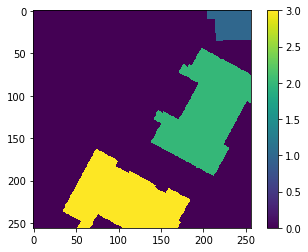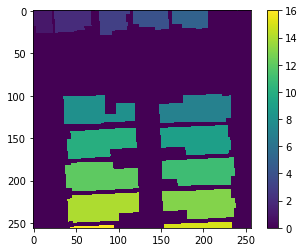

2. Weighting buildings based on area 


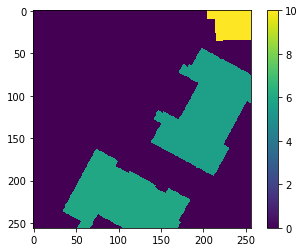
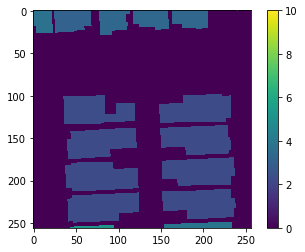

Weight Pixel based on distance from the nearest building

1. distance in pixels


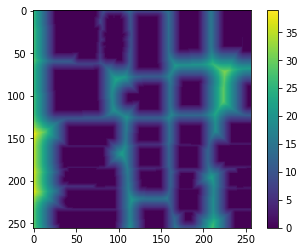

2. Weights

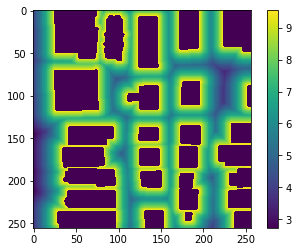

Since those weights has to be specific for each image considered and to avoid recomputing every time during training all the weights an additional channel is added to each target mask and then separated when computing the loss or the metric.

It can be easily integrated with custom dataset generator.

In [0]:

def prepare_mask(x):
    
    # Exploit the last channel of the image to carry a weighting coefficient
    # In order to avoid setting a too high penalty on specific pixels we let those 
    # weight coefficient to take values between 1 and 10

    # 1. Due to distance
    # numpy:
    # Although not completely clear from documentatiotn but distance_transform_edt 
    # computes the distance from non-zero (i.e. non-background) points to
    # the nearest zero (i.e. background) point.
    weight_distance = ndimage.distance_transform_edt(x == 0)
    
    weight_distance = np.where(weight_distance <= 0, weight_distance.max(),weight_distance)
    weight_distance =10*np.exp(-weight_distance/30)
    #2. weight due to area
    lbl, nlbl = ndimage.label(x)
    def fn(val, pos):
        
        return val.sum()

    area = ndimage.labeled_comprehension(x, lbl, range(1,nlbl+1), fn, float, 0, True)

    weigth_area = np.where( lbl == 0 , 0 , np.log(area.max()/area[lbl-1] )+1)
    weigth_area = weigth_area*10/weigth_area.max()

    weights = tf.cast( weigth_area + weight_distance +1 ,tf.float32) 
    #weights = tf.cast( weight_distance +1,tf.float32) 
    x = tf.cast(x, tf.float32)/255.0

    return np.concatenate( [tf.expand_dims(x, axis=-1), np.expand_dims(weights, axis=-1)], axis=-1)


the loss/IoU functions were rewritten to take into account the fact that the target dataset has two components.

In [0]:
def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    #Divide the real y_true and the weight mask
    y_true , area_w = tf.split(y_true,[1,1], axis=-1)
    w = tf.cast(area_w[:,:,:,:], tf.float32)

    return w*tf.keras.losses.binary_crossentropy(y_true, y_pred) + 5.*dice_loss(y_true, y_pred)
    
    
def IoU(y_true, y_pred):
    #Divide the real y_true and the weight mask
    y_true , area_w = tf.split(y_true,[1,1], axis=-1)
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

2. Combine together different cost functions

In [0]:
def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + 5.*dice_loss(y_true, y_pred)
    